### Imports

In [24]:
import pandas as pd
import numpy as np
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
%matplotlib inline

### Functions

In [25]:
def manual_ewm(df, alpha, result_col_name="Manual"):
    manual_ewma = []
    for x in df["Passengers"].to_numpy():
        if len(manual_ewma) > 0:
            xhat = alpha * x + (1 - alpha) * manual_ewma[-1]
        else:
            xhat = x
        manual_ewma.append(xhat)
    df[result_col_name] = manual_ewma

### Code

In [2]:
df = pd.read_csv("airline_passengers.csv", index_col="Month", parse_dates=True)

In [3]:
df.head()

,Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


In [4]:
df.isna().sum()

Passengers    0
dtype: int64

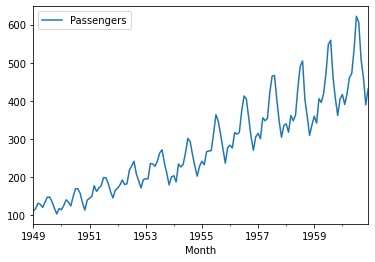

In [6]:
df.plot();

In [7]:
alpha = 0.2

In [9]:
df["EWMA"] = df["Passengers"].ewm(alpha=alpha, adjust=False).mean()

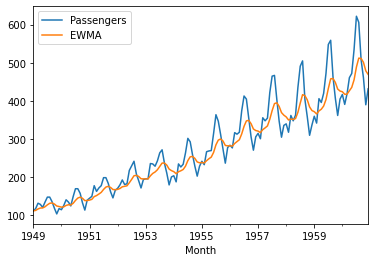

In [12]:
df.plot();

In [13]:
type(df["Passengers"].ewm(alpha=alpha, adjust=False))

pandas.core.window.ewm.ExponentialMovingWindow

In [18]:
manual_ewm(df=df, alpha=alpha, result_col_name="Manual")

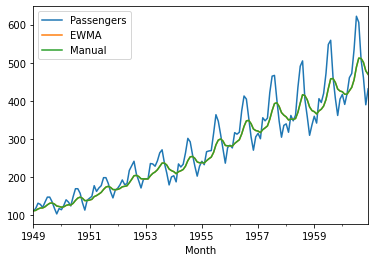

In [19]:
df.plot();

In [22]:
df.head()

,Passengers,EWMA,Manual
Month,,,
1949-01-01,112,112.0000,112.0000
1949-02-01,118,113.2000,113.2000
1949-03-01,132,116.9600,116.9600
1949-04-01,129,119.3680,119.3680
1949-05-01,121,119.6944,119.6944


In [23]:
df.drop("Manual", axis=1, inplace=True)